<a href="https://colab.research.google.com/github/sebcalcagno/AnalisisSeriesTemporales/blob/main/CLASE_4/AST_Clase_4_ejercicio_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="alert alert-block alert-info">
    <h1>Análisis de Series Temporales</h1>
    <h3>Clase 4</h3>
    <h3>Ejercicio 2</h3>
        <p>Docente: Rodrigo Del Rosso<p>
        <p>Asistentes: Sebastián Calcagno / Fernando Martínez<p> 
</div>

Los datos se obtienen de la siguiente fuente = https://datos.gob.ar/dataset/turismo-encuesta-**ocupacion**-hotelera-parahotelera-eoh/archivo/turismo_d1624c27-4b0d-4b73-b0f8-e7db5c56386f . <br>Es la cantidad de viajeros alojados en establecimientos hoteleros y parahoteleros según residencia en formato de series de tiempo.

# Preparacion de las bases a trabajar

In [ ]:
# !pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 6.7 MB/s 
     |████████████████████████████████| 9.8 MB 25.7 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import statsmodels.tsa.stattools as tsa
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima.utils import ndiffs
from pmdarima.arima import ADFTest
from matplotlib import pyplot

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima, ndiffs, nsdiffs
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.stats.diagnostic import acorr_ljungbox, acorr_breusch_godfrey
from scipy.stats import jarque_bera, shapiro, boxcox, probplot
from datetime import timedelta

In [ ]:
url='https://raw.githubusercontent.com/sebcalcagno/AnalisisSeriesTemporales/main/base_clase4.csv'
serie_inicial = pd.read_csv(url) 

In [ ]:
serie_inicial.indice_tiempo = pd.to_datetime(serie_inicial.indice_tiempo, dayfirst = True) 

In [ ]:
serie_inicial.set_index("indice_tiempo", inplace=True)

In [ ]:
# Verificamos que el indice sea del tipo DatetimeIndex
print(serie_inicial.index)

# Exploramos los primeros y los ultimos datos de la serie
print(serie_inicial)

DatetimeIndex(['2007-01-01', '2007-01-01', '2007-02-01', '2007-02-01',
               '2007-03-01', '2007-03-01', '2007-04-01', '2007-04-01',
               '2007-05-01', '2007-05-01',
               ...
               '2021-12-01', '2021-12-01', '2022-01-01', '2022-01-01',
               '2022-02-01', '2022-02-01', '2022-03-01', '2022-03-01',
               '2022-04-01', '2022-04-01'],
              dtype='datetime64[ns]', name='indice_tiempo', length=368, freq=None)
              origen_viajeros  viajeros    observaciones
indice_tiempo                                           
2007-01-01         Residentes   1679499              NaN
2007-01-01      No residentes    464201              NaN
2007-02-01         Residentes   1493372              NaN
2007-02-01      No residentes    479876              NaN
2007-03-01         Residentes   1285612              NaN
...                       ...       ...              ...
2022-02-01      No residentes    115315  Dato provisorio
2022-03-01    

In [ ]:
# Removemos la fila de observaciones ya que no aporta informacion relevante.
serie_inicial = serie_inicial.drop(['observaciones'],axis=1)

# Filtramos las series
# Nos quedamos con la serie de residentes
serie_residentes = serie_inicial[serie_inicial["origen_viajeros"]=="Residentes"].drop("origen_viajeros",1)
serie_no_residentes = serie_inicial[serie_inicial["origen_viajeros"]=="No residentes"].drop("origen_viajeros",1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  import sys


In [ ]:
print(type(serie_residentes))

<class 'pandas.core.frame.DataFrame'>


In [ ]:
# Conviertimos el dataframe en una serie
serie_residentes = serie_residentes.iloc[:,0]

# Verificamos que sea una serie
print(type(serie_residentes))

# Utilizamos la funcion de Pandas para inferir la frequencia (mensual)
serie_residentes = serie_residentes.asfreq(pd.infer_freq(serie_residentes.index))

# Corroboramos que la frecuencia sea mensual -> freq='MS'
print(serie_residentes.index)

<class 'pandas.core.series.Series'>
DatetimeIndex(['2007-01-01', '2007-02-01', '2007-03-01', '2007-04-01',
               '2007-05-01', '2007-06-01', '2007-07-01', '2007-08-01',
               '2007-09-01', '2007-10-01',
               ...
               '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01',
               '2021-11-01', '2021-12-01', '2022-01-01', '2022-02-01',
               '2022-03-01', '2022-04-01'],
              dtype='datetime64[ns]', name='indice_tiempo', length=184, freq='MS')


In [ ]:
# Funcion para graficar.
def graficar(serie, titulo="", xlabel="Año", ylabel="Pasajeros"):
    fig_x = plt.figure(figsize=(12,3), dpi=100)
    axes_x = fig_x.add_axes([0.0, 0.0, 1, 1])
    serie.plot()
    axes_x.set_xlabel(xlabel)
    axes_x.set_ylabel(ylabel)
    axes_x.set_title(titulo)
    axes_x.legend(loc=0)
    axes_x.grid(True, color='0.6', dashes=(5,2,1,2))

In [ ]:
# Verificamos si hay nulos, y corroboramos que no los hay
print(serie_residentes.isnull().values.any())

False


In [ ]:
serie_residentes.describe()

count    1.840000e+02
mean     1.198095e+06
std      3.554625e+05
min      0.000000e+00
25%      1.071885e+06
50%      1.244284e+06
75%      1.389307e+06
max      1.800900e+06
Name: viajeros, dtype: float64

Las series muestran una tendencia estacional, con un cambio abruto por pandemia. Queda a criterio del profesional que hacer con ese periodo. 

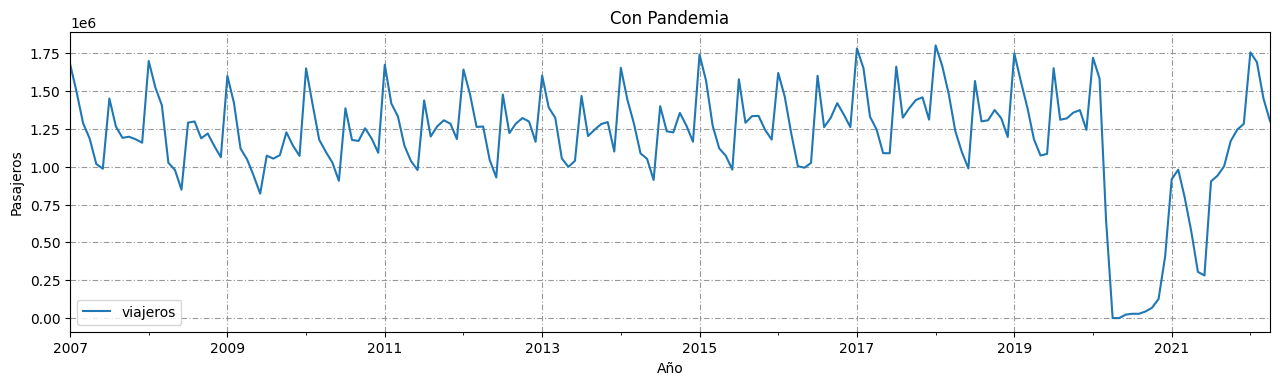

In [ ]:
graficar(serie_residentes, "Con Pandemia")

Vemos que la serie , sin los efectos de pandemia, tienen un comportamiento posible a analizar. Mas adelante optaremos por esta opcion. 

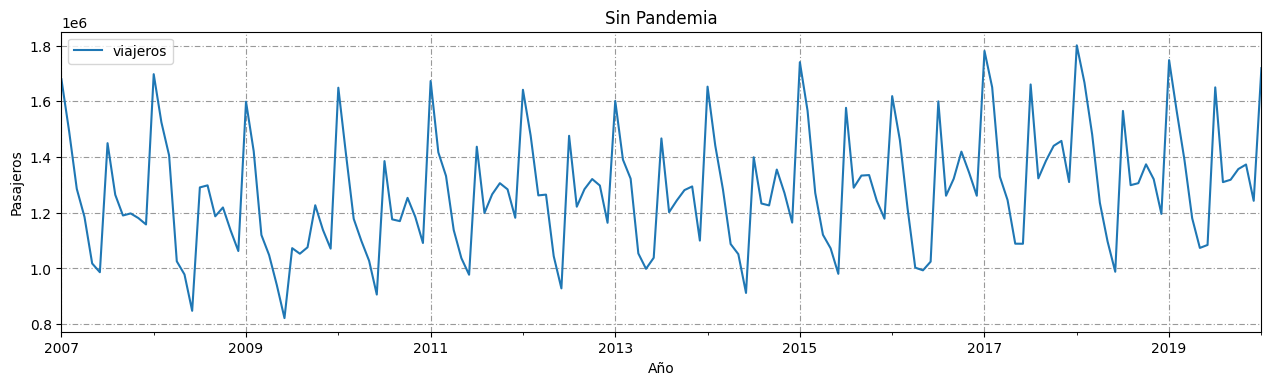

In [ ]:
serie_residentes_cut = pd.Series(serie_residentes[serie_residentes.index <= '2020-01-01'])
graficar(serie_residentes_cut, "Sin Pandemia")

In [ ]:
def print_test_afd(y):
  resultado = tsa.adfuller(y)
  print('Estadistico ADF: %f' % resultado[0])
  print('p-valor: %f' % resultado[1])
  print('Valores criticos:')
  for key, valor in resultado[4].items():
    print('\t%s: %.3f' % (key, valor))

In [ ]:
def test_stationarity(timeseries):

    #Rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 6))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

Analisis de estacionariedad de las series de residentes, sin los efectos de la pandemia. Analizamos mediante una prueba de Dickey-Fuller Aumentada. <br>En base a los resultados del test ADF, no se rechaza la hipótesis nula y se concluye que la serie de Residentes no es estacionaria (p-valor>0.05).

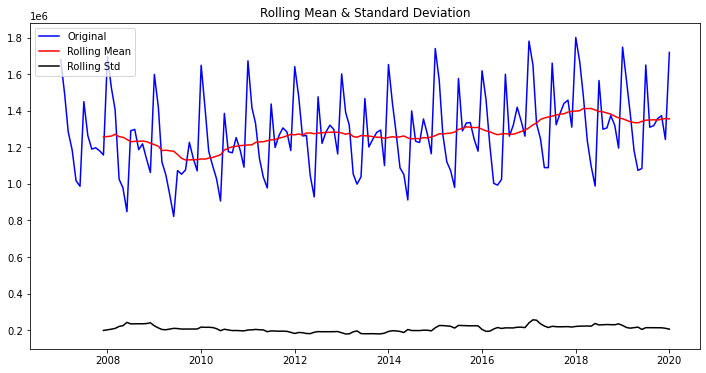

Estadistico ADF: -1.138184
p-valor: 0.699607
Valores criticos:
	1%: -3.477
	5%: -2.882
	10%: -2.578


In [ ]:
test_stationarity(serie_residentes_cut)
print_test_afd(serie_residentes_cut)

In [ ]:
def estacionario(y):
  # Estimado de número de diferencias con ADF test:Dickey-Fuller
  n_adf = ndiffs(y, test='adf')  # -> 0
  
  # KPSS test (auto_arima default): Kwiatkowski-Phillips-Schmidt-Shin
  n_kpss = ndiffs(y, test='kpss')  # -> 0
  
  # PP test: Phillips-Perron
  n_pp = ndiffs(y, test='pp')  # -> 0

  print('Estimado de número de diferencias con ADF test')
  print(n_adf)
  
  print('Estimado de número de diferencias con KPSS test')
  print(n_kpss)
  
  print('Estimado de número de diferencias con PP test')
  print(n_pp)
  
  print('Se debe realizar diferenciación (should_diff) ADF Test')
  adftest = ADFTest(alpha=0.05)
  print(adftest.should_diff(y))

A continuacion, analizamos mediante diferentes pruebas el orden de diferenciacion requerido para que la serie pueda llegar a ser estacionaria. Este es un analizis complementario, junto con los otros realizados. <br>
Las pruebas realizadas son:
<ol>
  <li>Prueba de Dickey-Fuller aumentada</li>
  <li>Prueba de Kwiatkowski-Phillips-Schmidt-Shin</li>
  <li>Prueba de Phillips-Perron</li>
</ol>


In [ ]:
estacionario(serie_residentes_cut)

Estimado de número de diferencias con ADF test
0
Estimado de número de diferencias con KPSS test
1
Estimado de número de diferencias con PP test
0
Se debe realizar diferenciación (should_diff) ADF Test
(0.017474006192913727, False)


indice_tiempo
2007-02-01   -186127.0
2007-03-01   -207760.0
2007-04-01   -100675.0
2007-05-01   -167116.0
2007-06-01    -31433.0
                ...   
2019-09-01      8637.0
2019-10-01     38353.0
2019-11-01     16262.0
2019-12-01   -130247.0
2020-01-01    476296.0
Freq: MS, Name: viajeros, Length: 156, dtype: float64


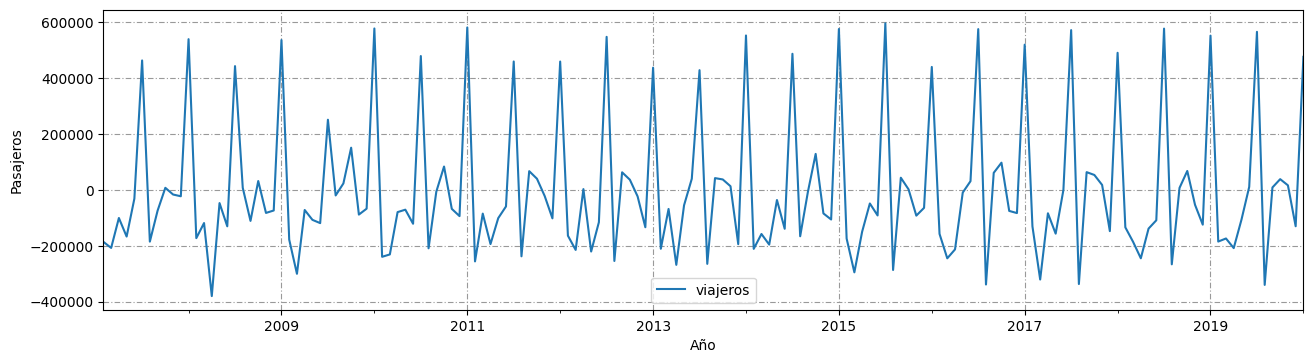

In [ ]:
# Realizamos una primera diferencia para ver si podemos lograr que la serie sea estacionaria
serie_residentes_cut_diff_1 = serie_residentes_cut - serie_residentes_cut.shift(1)
serie_residentes_cut_diff_1= serie_residentes_cut_diff_1.dropna()
graficar(serie_residentes_cut_diff_1)
print(serie_residentes_cut_diff_1)

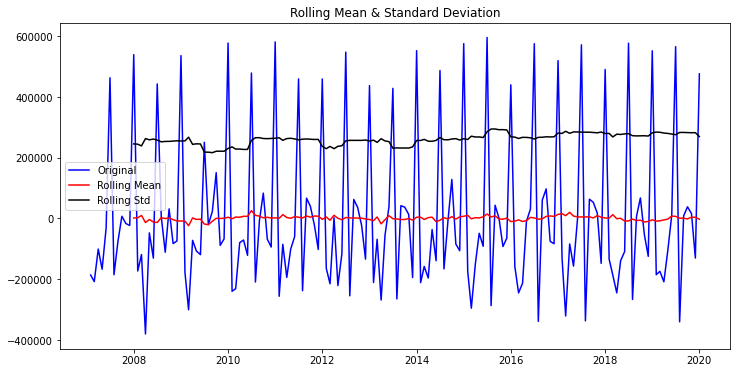

Estadistico ADF: -4.417370
p-valor: 0.000277
Valores criticos:
	1%: -3.477
	5%: -2.882
	10%: -2.578


In [ ]:
test_stationarity(serie_residentes_cut_diff_1)
print_test_afd(serie_residentes_cut_diff_1)

En base a los resultados del test ADF, se rechaza la hipótesis nula y se concluye que la serie de Residentes es estacionaria en base a los datos (p-valor<0.05). Pero, se mantiene la estacionalidad anual

In [ ]:
# Ahora realizamos otra prueba adicional ("ndiffs") como comprobacion adicional para corrobar el numero de diferencias necesarias para que la serie sea estacionaria.
ndiffs(serie_residentes_cut, max_d=10)

1

In [ ]:
## Función para dibujar juntos FAS: autocovarianzas; FAC y FACP, autocorrelación y autocorrelación parcial
def autocov_autocorr(serie_r,serie_nr, nrol= 75 ):
  p1, axes=plt.subplots(3,2,figsize=(18,10),sharex=True, sharey=False )
  axes[2,0].set_xlabel('Lag')
  axes[2,1].set_xlabel('Lag')
  
  plot_acf(serie_r, lags=nrol, ax= axes[0,0], color='blue', label="ACF", vlines_kwargs={"colors":'blue'}, title='Serie 1: Residentes')
  plot_pacf(serie_r, lags=nrol, ax= axes[1,0], color='green', label="PACF", vlines_kwargs={"colors":'green'}, title='', method='ywm')
  axes[2,0].plot(tsa.acovf(serie_r,fft=False, nlag=nrol), color='r', label='AutoCov')
  
  plot_acf(serie_nr, lags=nrol, ax= axes[0,1], color='blue', label="ACF", vlines_kwargs={"colors":'blue'}, title='Repito grafico: Residentes')
  plot_pacf(serie_nr, lags=nrol, ax= axes[1,1], color='green', label="PACF", vlines_kwargs={"colors":'green'}, title='', method='ywm')
  axes[2,1].plot(tsa.acovf(serie_nr,fft=False, nlag=nrol), color='r', label='AutoCov')

  p1.legend()
  plt.show()

In [ ]:
len(serie_residentes_cut)/2

78.5

observación importante es que los picos repetitivos muestran evidencia de posible estacionalidad

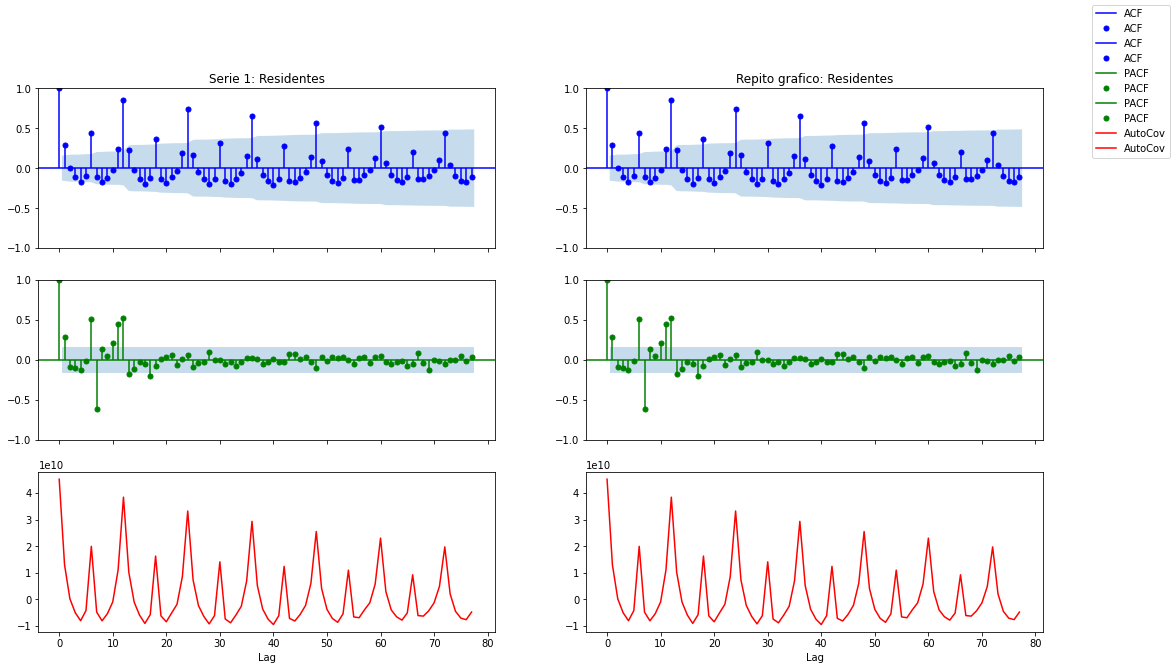

In [ ]:
# Grafica para ver en el tiempo los ciclos y cómo decae a cero
# En ambas series lo hace por lo que podemos observar que es un proceso autoregresivo
# utilizamos el máximo lag sugerido como <78 (< len(serie)/2)
autocov_autocorr(serie_residentes_cut,serie_residentes_cut, 77)

Haciendo un zoom en la grafica, se vuelve a observar los picos repentinos en diferentes lags que muestgran posible estacionalidad. 

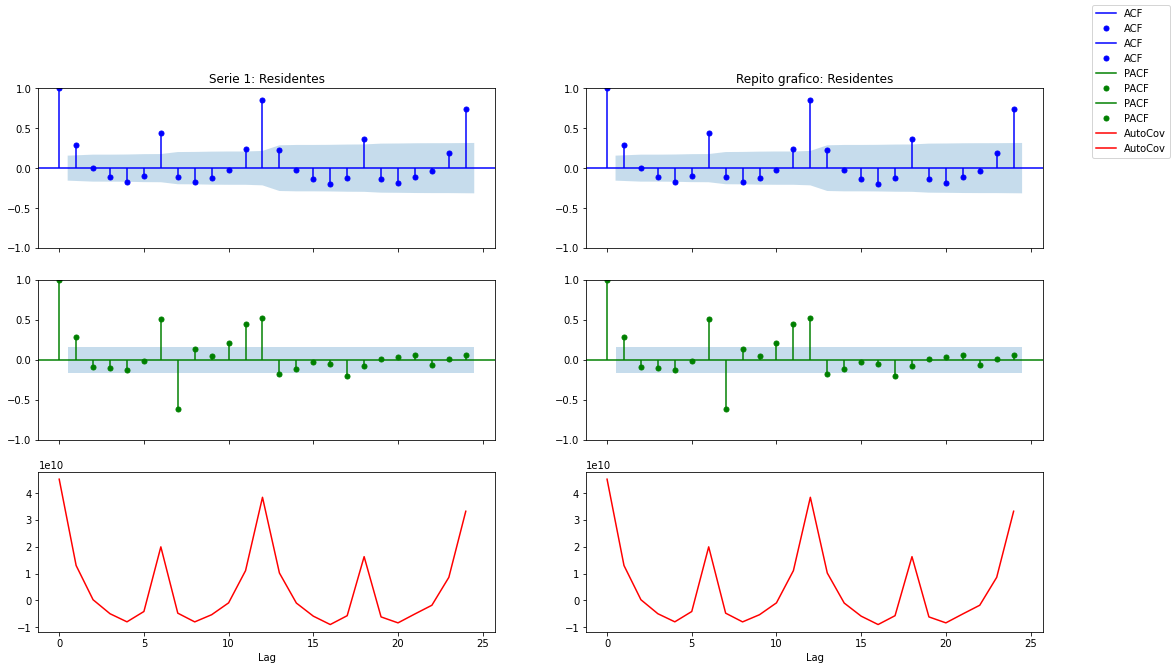

In [ ]:
autocov_autocorr(serie_residentes_cut, serie_residentes_cut ,24)

In [ ]:
# Esta función descompone la serie en sus partes para ver estacionalidad, tendencia, residuos 
def componentes(timeserie):
  decomposition = seasonal_decompose(timeserie, period=12)
  fig = plt.figure()
  fig = decomposition.plot()
  fig.set_size_inches(15, 8)

<Figure size 432x288 with 0 Axes>

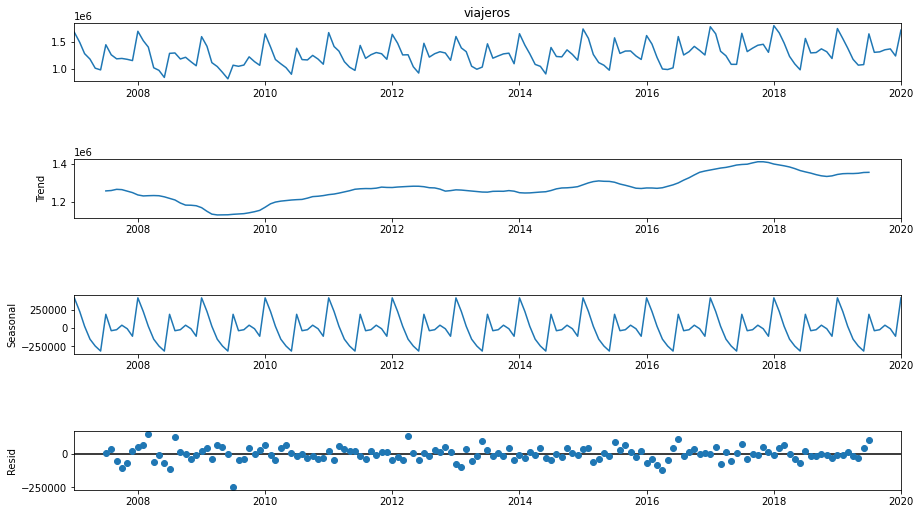

In [ ]:
componentes(serie_residentes_cut)

Ahora vemos la grafica de ACF y PACF para la serie diferenciada en orden 1 de Residentes, se observan picos, lo cual es un indicativo de estacionalidad. La autocorrelación parcial por otra parte, evidencia en los lagsl 1 y 2, los primeros puntos significativos a tener en cuenta para el orden de la autoregresión

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


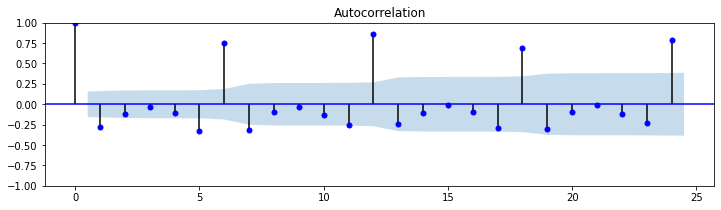

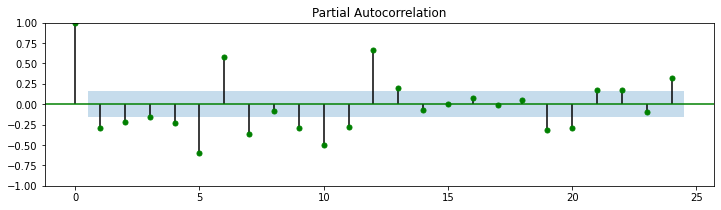

In [ ]:
acf_plot = plot_acf(serie_residentes_cut_diff_1, lags=24,  color= 'blue')
acf_plot.set_size_inches(12,3)

pacf_plot = plot_pacf(serie_residentes_cut_diff_1, lags=24, color= 'green')
pacf_plot.set_size_inches(12,3)

indice_tiempo
2008-02-01     13311.0
2008-03-01     89002.0
2008-04-01   -279558.0
2008-05-01    119871.0
2008-06-01    -99089.0
                ...   
2019-09-01      1492.0
2019-10-01    -29305.0
2019-11-01     69649.0
2019-12-01     -5682.0
2020-01-01    -75799.0
Freq: MS, Name: viajeros, Length: 144, dtype: float64

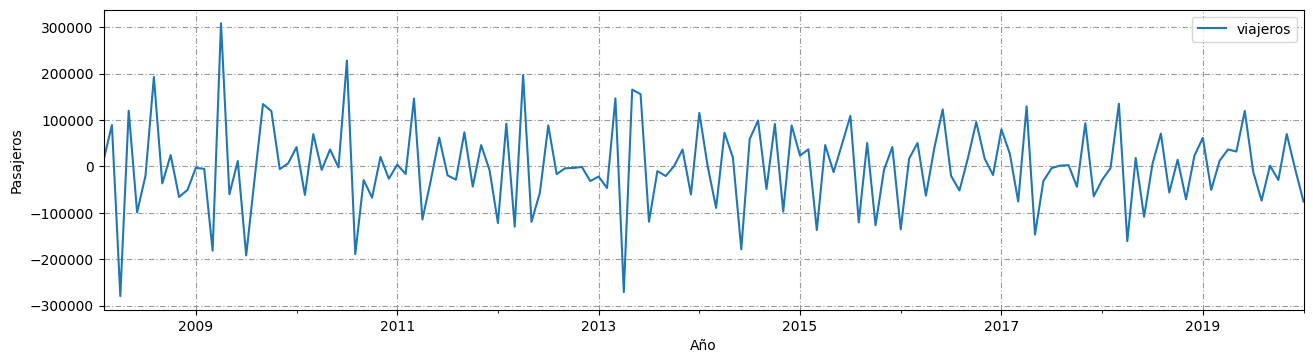

In [ ]:
# Para remover la estacionalidad anual, hacemos una diferencia de 12 meses y en el grafico ya no observamos  
# un patron repetitivo
serie_residentes_cut_diff_12 = serie_residentes_cut_diff_1 - serie_residentes_cut_diff_1.shift(12)
serie_residentes_cut_diff_12= serie_residentes_cut_diff_12.dropna()
graficar(serie_residentes_cut_diff_12)
serie_residentes_cut_diff_12

In [ ]:
# Utilizamos la funcion nsdiffs como comprobacion adicional para corrobar el numero de diferencias necesarias para que 
# la serie no sea estacional y el resultado devuelto es una diferenciacion
nsdiffs(serie_residentes_cut_diff_1, m=12)

1

In [ ]:
nsdiffs(serie_residentes_cut_diff_12, m=12)

0

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


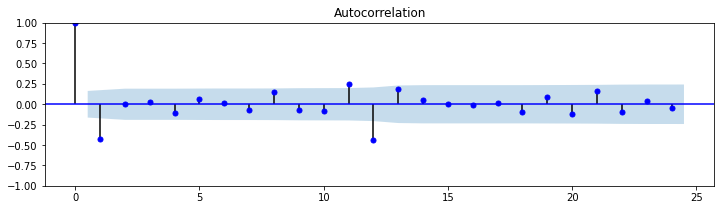

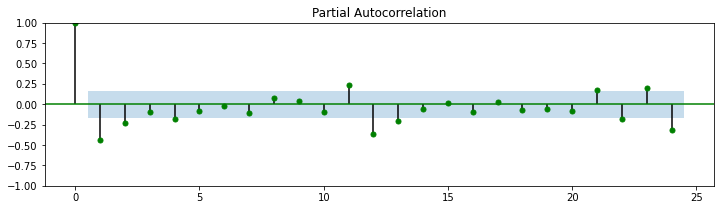

In [ ]:
acf_plot = plot_acf(serie_residentes_cut_diff_12, lags=24, color= 'blue')
pacf_plot = plot_pacf(serie_residentes_cut_diff_12, lags=24, color= 'green')

pacf_plot.set_size_inches(12,3)
acf_plot.set_size_inches(12,3)

In [ ]:
# Funcion para graficar las predicciones.
# Toma como parametros:
# serie_test: la porcion de la serie con los datos de test
# serie_pred: las predicciones hechas por el modelo
# conf_int: el intervalo de confianza de las predicciones

def graficar_pred(serie_test, serie_pred, conf_int, titulo="Valores Originales vs Predicciones", xlabel="Año", ylabel="Pasajeros"):
    fig_x = plt.figure(figsize=(12,3), dpi=100)
    axes_x = fig_x.add_axes([0.0, 0.0, 1, 1])
    
    # Graficamos los datos tests y las predicciones
    serie_test.plot(label="Serie Original de Test")
    serie_pred.plot(label="Predicciones")
    
    # Pasamos dataframe con los intervalos de confianza a series de Pandas y graficamos
    conf_int.iloc[:,1].plot(label="Intervalo de Confianza Superior")
    conf_int.iloc[:,0].plot(label="Intervalo de Confianza Inferior")
    
    axes_x.set_xlabel(xlabel)
    axes_x.set_ylabel(ylabel)
    axes_x.set_title(titulo)
    axes_x.legend(loc=0)
    axes_x.grid(True, color='0.6', dashes=(5,2,1,2))

In [ ]:
def evaluar_metricas(serie_test, serie_pred):
    print(f'MSE: {mean_squared_error(serie_test, serie_pred)}')
    print(f'MAE: {mean_absolute_error(serie_test, serie_pred)}')
    print(f'RMSE: {np.sqrt(mean_squared_error(serie_test, serie_pred))}')
    print(f'MAPE: {round(np.mean(abs((serie_test-serie_pred)/serie_test)),4)}')

In [ ]:
# Separacion Train/Test
# Seleccionamos el primer 80% para train
train = serie_residentes_cut.iloc[:round(len(serie_residentes_cut)*.8)]
# Seleccionamos el 20% restante para test
test = serie_residentes_cut.iloc[round(len(serie_residentes_cut)*.8):]
# Corroboramos que los limites se hayan establecido segun lo planificado
print(train, test)

indice_tiempo
2007-01-01    1679499
2007-02-01    1493372
2007-03-01    1285612
2007-04-01    1184937
2007-05-01    1017821
               ...   
2017-02-01    1650309
2017-03-01    1329411
2017-04-01    1245606
2017-05-01    1088862
2017-06-01    1088614
Freq: MS, Name: viajeros, Length: 126, dtype: int64 indice_tiempo
2017-07-01    1660519
2017-08-01    1323414
2017-09-01    1386911
2017-10-01    1440231
2017-11-01    1457877
2017-12-01    1310199
2018-01-01    1800900
2018-02-01    1666664
2018-03-01    1480667
2018-04-01    1235730
2018-05-01    1097071
2018-06-01     988183
2018-07-01    1565479
2018-08-01    1298976
2018-09-01    1306121
2018-10-01    1373779
2018-11-01    1320392
2018-12-01    1195827
2019-01-01    1747922
2019-02-01    1562882
2019-03-01    1388867
2019-04-01    1180396
2019-05-01    1073666
2019-06-01    1084275
2019-07-01    1650061
2019-08-01    1309835
2019-09-01    1318472
2019-10-01    1356825
2019-11-01    1373087
2019-12-01    1242840
2020-01-01    1719

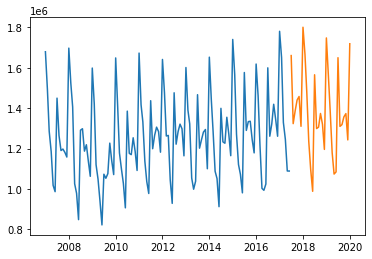

In [ ]:
plt.plot(train)
plt.plot(test)

# MODELO SARIMA (2,1,1), (1,1,1)12   ( CON PARAMETROS ELEGIDOS SEGUN EL ANALISIS PREVIO) 

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


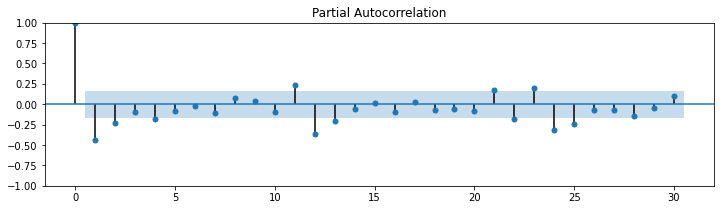

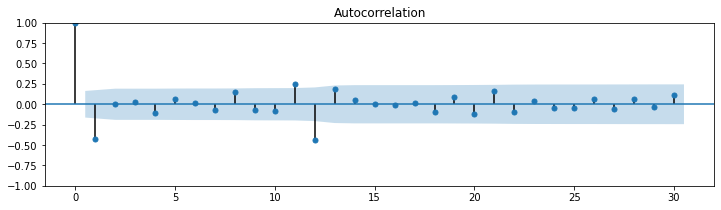

In [ ]:
# Graficamos las autocorrelaciones para seleccionar los parametros del modelo

# Para la parte estacionaria, para AR consideramos 2 lags significativos; para MA consideramos 1 lag significativo
# Para la parte estacional consideramos significativos lags en la posicion 12.

pacf_plot = plot_pacf(serie_residentes_cut_diff_12, lags=30)
acf_plot = plot_acf(serie_residentes_cut_diff_12, lags=30)
pacf_plot.set_size_inches(12,3)
acf_plot.set_size_inches(12,3)

In [ ]:
# Dado que es una serie que presenta estacionalidad (seasonality) vamos a utilizar un modelo SARIMA que es una
# Arima que permite tratar el componente estacional (Vishwas & Patel, 2020). Los parametros del modelo son:

# SARIMA(p, d, q)(P, D, Q)m

# A partir de los graficos ACF y PCF optamos por tomar: p=2, q=1, P=1, Q=1 como se menciono anteriormente
# Con estos valores generamos el modelo, lo entrenamos e imprimimos los resultados
modelo1 = SARIMAX(train, order=(2,1,1), seasonal_order=(1,1,1,12))
modelo1_fit = modelo1.fit()
print(modelo1_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                           viajeros   No. Observations:                  126
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1440.932
Date:                            Fri, 15 Jul 2022   AIC                           2893.864
Time:                                    16:20:45   BIC                           2910.229
Sample:                                01-01-2007   HQIC                          2900.505
                                     - 06-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3025      1.144      0.264      0.792      -1.940       2.545
ar.L2          0.1319      0.143   

Los valores de p-value en la columna PZ|z| nos indica que los parámetros para la parte estacionaria no son significativos; y que sólo los correspondientes a la parte estacional sí lo son. Por lo que este no es un buen modelo

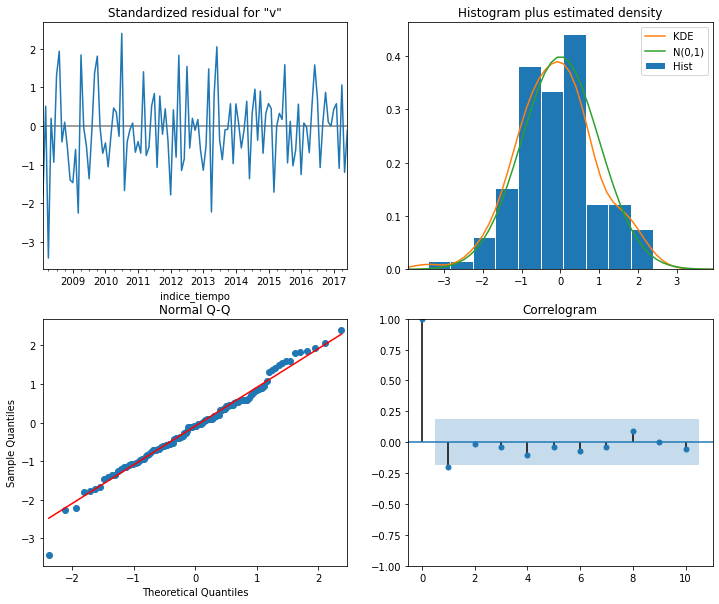

In [ ]:
# Diagnostico grafico los residuos del modelo
fig_res_1 = modelo1_fit.plot_diagnostics(figsize=(12,10))

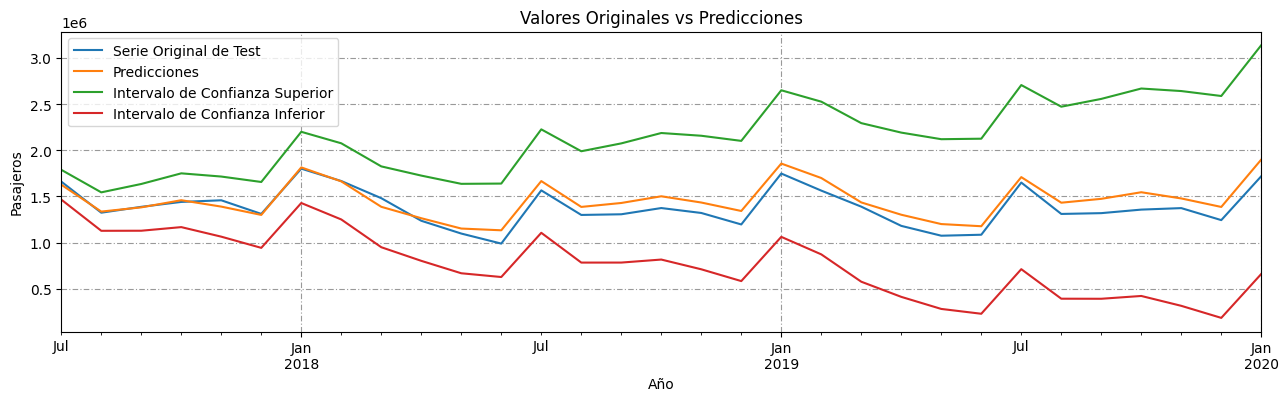

In [ ]:
# Utilizando el modelo realizamos la prediccion correspondiente al periodo de test
predicciones1 = modelo1_fit.get_forecast(len(test))

# Graficamos la porcion de test de la serie original junto con las predicciones y los intervalos de confianza
graficar_pred(test, predicciones1.predicted_mean, predicciones1.conf_int())

In [ ]:
evaluar_metricas(test, predicciones1.predicted_mean)

MSE: 10859415398.32074
MAE: 89245.13019581827
RMSE: 104208.51883757267
MAPE: 0.0673


Modelo SARIMA (0,1,0), (1,1,1)12

In [ ]:
# Observamos que los coeficientes correspondientes a la parte estacionaria, AR y MA, resultan ser 
# no significativos (p-valor mayor a 0.05)

# Probamos con un modelo con dichos coeficientes en 0 y observamos que, si bien los coeficientes de la parte
# estacional se mantienen significativos como en el modelo anterior, aumenta el AIC

# Generamos el modelo, lo entrenamos e imprimimos los resultados
modelo2 = SARIMAX(train, order=(0,1,0), seasonal_order=(1,1,1,12))
modelo2_fit = modelo2.fit()
print(modelo2_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                             viajeros   No. Observations:                  126
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 12)   Log Likelihood               -1444.811
Date:                              Fri, 15 Jul 2022   AIC                           2895.621
Time:                                      16:21:03   BIC                           2903.803
Sample:                                  01-01-2007   HQIC                          2898.941
                                       - 06-01-2017                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.2071      0.086      2.397      0.017       0.038       0.376
ma.S.L12      -0.67

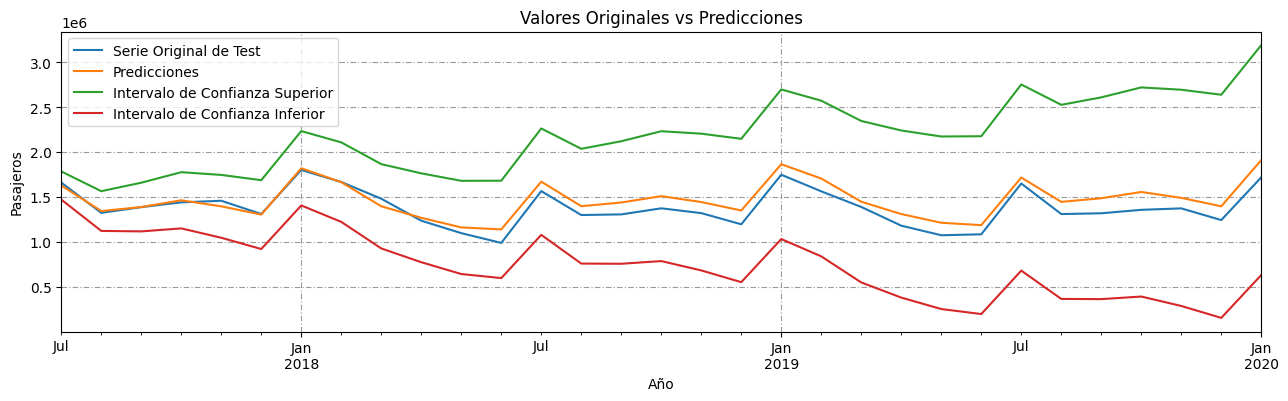

In [ ]:
# Utilizando el modelo realizamos la prediccion correspondiente al periodo de test
predicciones2 = modelo2_fit.get_forecast(len(test))

# Graficamos la porcion de test de la serie original junto con las predicciones y los intervalos de confianza
graficar_pred(test, predicciones2.predicted_mean, predicciones2.conf_int())

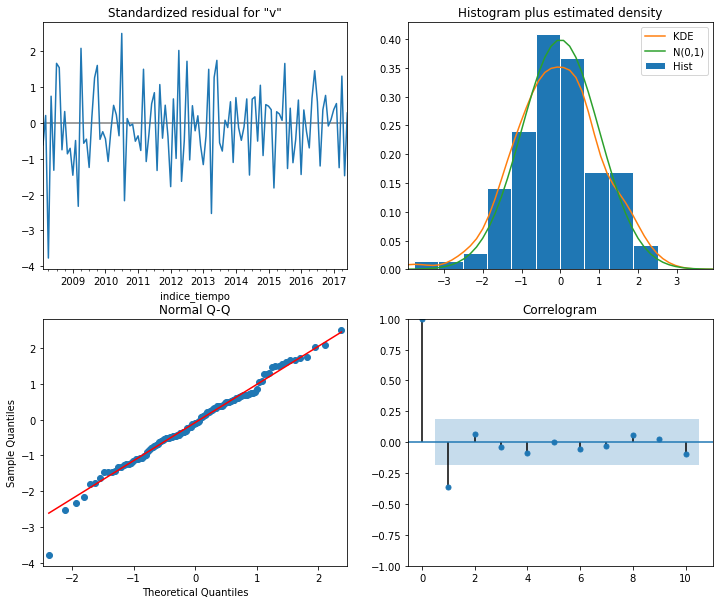

In [ ]:
# Diagnostico grafico los residuos del modelo
fig_res_2 = modelo2_fit.plot_diagnostics(figsize=(12,10))

In [ ]:
modelo2_fit.resid.describe()

count    1.260000e+02
mean    -1.458134e+03
std      1.866099e+05
min     -5.625698e+05
25%     -7.235718e+04
50%     -1.672335e+04
75%      4.348515e+04
max      1.679499e+06
dtype: float64

In [ ]:
evaluar_metricas(test, predicciones2.predicted_mean)

MSE: 12424972973.090792
MAE: 95638.59421494423
RMSE: 111467.36281571747
MAPE: 0.0723


# MODELO ARIMA (1,1,1) ( CON PARAMETROS ELEGIDOS AL AZAR, MUESTRAN QUE NOS ARROJA UN MAL MODELO) 

In [ ]:
modeloARMA = sm.tsa.arima.ARIMA(train, order=(1,1,1))
resultadoARMA = modeloARMA.fit()

resultadoARMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               viajeros   No. Observations:                  126
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1705.663
Date:                Fri, 15 Jul 2022   AIC                           3417.325
Time:                        16:22:26   BIC                           3425.810
Sample:                    01-01-2007   HQIC                          3420.772
                         - 06-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3175      0.106      3.000      0.003       0.110       0.525
ma.L1         -0.9721      0.050    -19.260      0.000      -1.071      -0.873
sigma2      5.102e+10   5.64e-13   9.05e+22      0.000     5.1e+10     5.1e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                20.53
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.09   Skew:                             0.98
Prob(H) (two-sided):                  0.77   Kurtosis:                         3.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.12e+37. Standard errors may be unstable.
"""

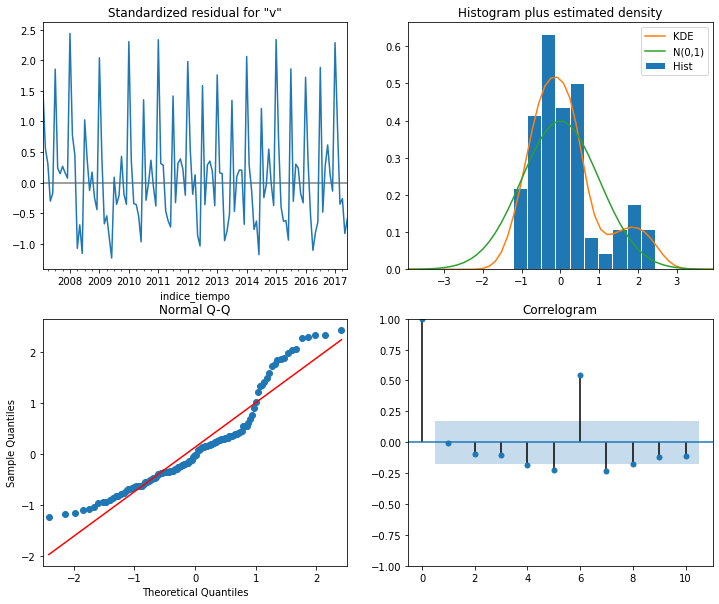

In [ ]:
# Diagnostico grafico los residuos del modelo
fig_res_1 = resultadoARMA.plot_diagnostics(figsize=(12,10))

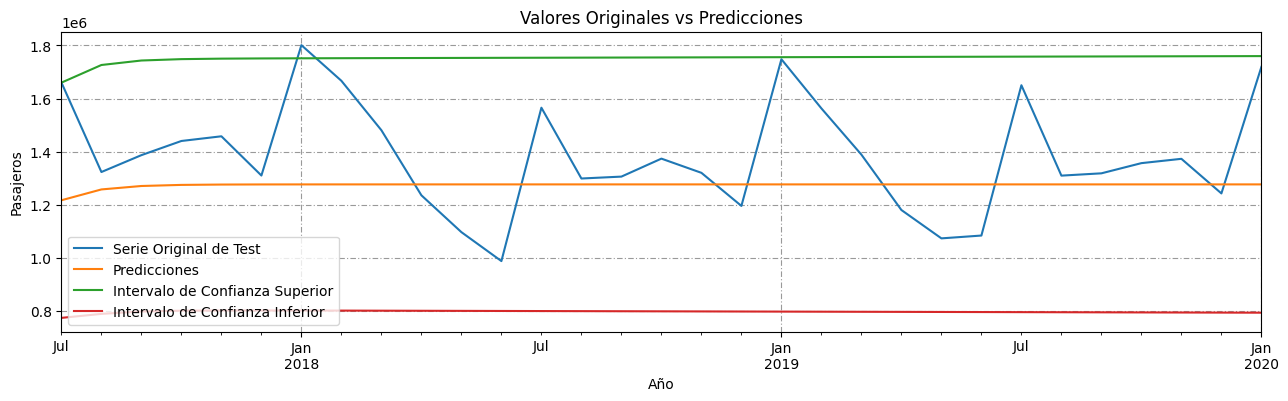

In [ ]:
# Utilizando el modelo realizamos la prediccion correspondiente al periodo de test
predicciones1 = resultadoARMA.get_forecast(len(test))

# Graficamos la porcion de test de la serie original junto con las predicciones y los intervalos de confianza
graficar_pred(test, predicciones1.predicted_mean, predicciones1.conf_int())

In [ ]:
evaluar_metricas(test, predicciones1.predicted_mean)

MSE: 55566777094.4162
MAE: 182466.66092764898
RMSE: 235726.06367225538
MAPE: 0.1255


# con el auto arima nos arroja el mejor modelo sarima segun criterio de informacion AIC

In [ ]:
# Utilizamos la funcion auto_arima del paquete pmdarima para optimizar la combinacion de hiperparametros 
# para el modelo SARIMA

auto_arima(train, start_p=0, max_p=5, start_d=0, max_d=5, start_q=0, max_q=5, 
           start_P=0, max_P=5, start_D=0, max_D=5, start_Q=0, max_Q=5,
           seasonal=True, m=12, trace=True, stepwise=True).summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2934.811, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2916.116, Time=0.24 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=2918.138, Time=0.24 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2935.126, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2926.962, Time=0.06 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=2904.147, Time=0.66 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=2902.146, Time=1.40 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=2902.418, Time=3.45 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=2900.790, Time=3.58 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=2904.421, Time=1.14 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=inf, Time=10.71 sec
 ARIMA(1,0,0)(3,1,2)[12] intercept   : AIC=2902.817, Time=7.22 sec
 ARIMA(1,0,0)(2,1,2)[12] intercept   : AIC=2903.288, Time=3.14 sec
 ARIMA(1,0,0)(4,1,2)[12] intercept   : AIC=inf, Time=11.37 sec
 ARIMA(0,0,0)(3,1,1)[12] in

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  126
Model:             SARIMAX(2, 0, 1)x(2, 1, [], 12)   Log Likelihood               -1439.651
Date:                             Fri, 15 Jul 2022   AIC                           2891.302
Time:                                     15:44:35   BIC                           2907.719
Sample:                                          0   HQIC                          2897.964
                                             - 126                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1563      0.080     14.537      0.000       1.000       1.312
ar.L2         -0.1890      0.072     -2.632      0.008      -0.330      -0.048
ma.L1         -0.9348      0.025    -36.688      0.000      -0.985      -0.885
ar.S.L12      -0.2315      0.052     -4.425      0.000      -0.334      -0.129
ar.S.L24      -0.1757      0.029     -6.043      0.000      -0.233      -0.119
sigma2      6.142e+09   1.14e-12    5.4e+21      0.000    6.14e+09    6.14e+09
===================================================================================
Ljung-Box (L1) (Q):                   1.07   Jarque-Bera (JB):                 0.34
Prob(Q):                              0.30   Prob(JB):                         0.84
Heteroskedasticity (H):               0.80   Skew:                            -0.11
Prob(H) (two-sided):                  0.51   Kurtosis:                         3.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.55e+37. Standard errors may be unstable.
"""

In [ ]:
# Utilizando el modelo realizamos la prediccion correspondiente al periodo de test
# predicciones2 = modelo2_fit.get_forecast(len(test))


# Graficamos la porcion de test de la serie original junto con las predicciones y los intervalos de confianza
#graficar_pred(test, predicciones2.predicted_mean, predicciones2.conf_int())

# arriba es mio
##########
print(modelo_opt_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                            viajeros   No. Observations:                  126
Model:             SARIMAX(2, 0, 1)x(2, 1, [], 12)   Log Likelihood               -1439.651
Date:                             Fri, 15 Jul 2022   AIC                           2891.302
Time:                                     15:25:26   BIC                           2907.719
Sample:                                 01-01-2007   HQIC                          2897.964
                                      - 06-01-2017                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1563      0.080     14.537      0.000       1.000       1.312
ar.L2         -0.1890      

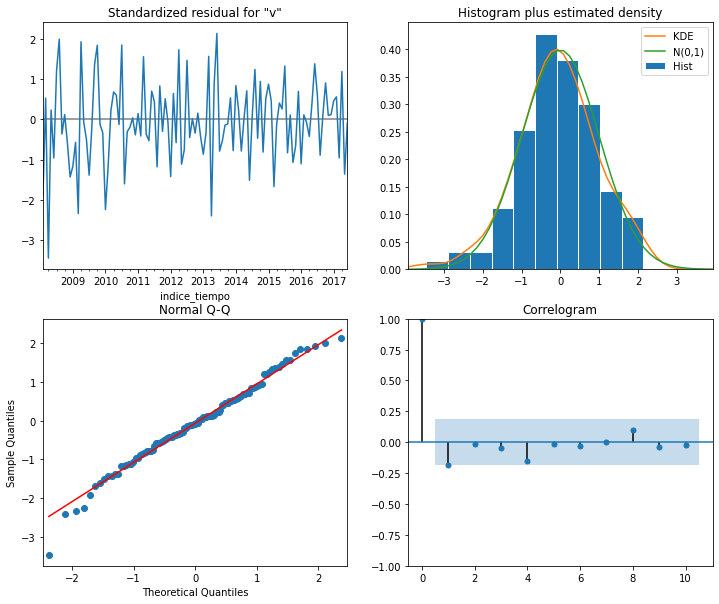

In [ ]:
# Diagnostico grafico los residuos del modelo
fig_res_modelo_opt = modelo_opt_fit.plot_diagnostics(figsize=(12,10))

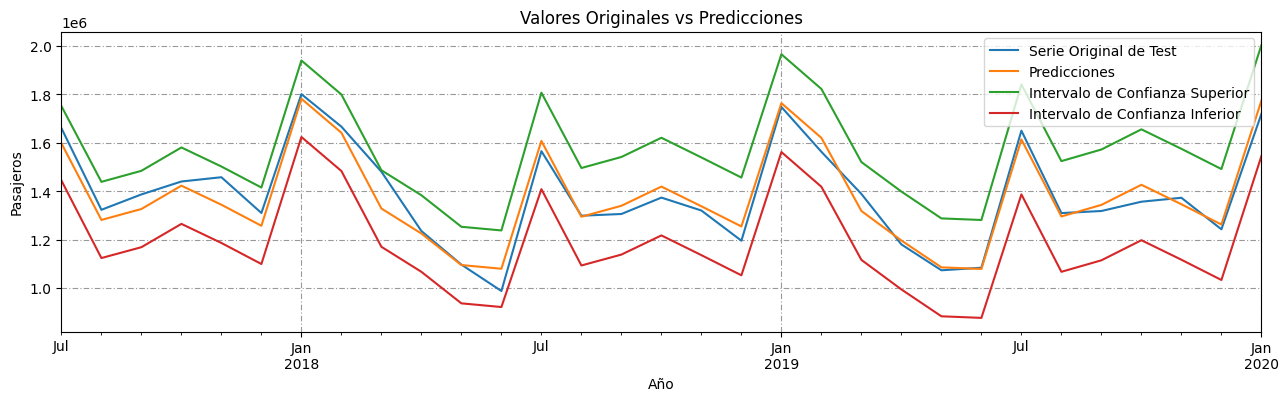

In [ ]:
# Obtenemos que la combinacion optima de hiperparametros responde a un modelo:

# SARIMA (2,0,1)(2,1,0)12

# Con esos valores generamos y entrenamos el modelo
modelo_opt = SARIMAX(train, order=(2,0,1), seasonal_order=(2,1,0,12))
modelo_opt_fit = modelo_opt.fit()

# Utilizando el modelo realizamos la prediccion correspondiente al periodo de test
predicciones_opt = modelo_opt_fit.get_forecast(len(test))

# Graficamos la porcion de test de la serie original junto con las predicciones y los intervalos de confianza
graficar_pred(test, predicciones_opt.predicted_mean, predicciones_opt.conf_int())

In [ ]:
evaluar_metricas(test, predicciones_opt.predicted_mean)

MSE: 2799364202.470402
MAE: 41099.6363094417
RMSE: 52909.01815825353
MAPE: 0.0298


Fin del codigo, muchas gracias! 